## IMPORTS

In [16]:
from tqdm import tqdm

In [17]:
import os
import numpy as np
import librosa
import soundfile as sf

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
import os
import numpy as np
import librosa
from tqdm import tqdm
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

In [37]:
import soundfile as sf


In [43]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [55]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
import os

folder_path = r"C:\Users\Dell\Downloads\emotion_det\final3\female"

wav_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')]



In [21]:
import os

def get_gender(filename):

    base = os.path.basename(filename)
    actor_id_str = base.split('-')[-1].split('.')[0]
    actor_id = int(actor_id_str)
    return 'male' if actor_id % 2 == 1 else 'female'



In [22]:
import os

def get_emotion_label(filename):
   
    base = os.path.basename(filename)
    parts = base.split('-')
    emotion_id = int(parts[2])
    return emotion_id - 1 



In [23]:
labels = []
for i in wav_files:
    labels.append(get_emotion_label(i))

## split train and test files 

In [24]:
train_files, test_files, train_labels, test_labels = train_test_split(
    wav_files, labels, test_size=0.2, random_state=42, stratify=labels
)

In [25]:
len(train_files)

963

In [26]:
# 

## AUGMENT

In [28]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=0.5),
    TimeStretch(min_rate=0.9, max_rate=1.1, p=0.7),
    PitchShift(min_semitones=-1.5, max_semitones=1.5, p=0.6),
    Shift(min_shift=-0.2, max_shift=0.2, shift_unit="fraction", p=0.5)
])

## extraction

In [39]:
def extract_features(audio, sr, n_mfcc=40, n_chroma=12, n_bands=6):
    stft = np.abs(librosa.stft(audio))

    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_processed = np.vstack([
        np.mean(mfccs, axis=1),
        np.std(mfccs, axis=1),
        np.median(mfccs, axis=1)
    ])

    chroma = librosa.feature.chroma_stft(S=stft, sr=sr, n_chroma=n_chroma)
    chroma_processed = np.vstack([
        np.mean(chroma, axis=1),
        np.std(chroma, axis=1)
    ])

    contrast = librosa.feature.spectral_contrast(S=stft, sr=sr, n_bands=n_bands)
    contrast_processed = np.vstack([
        np.mean(contrast, axis=1),
        np.std(contrast, axis=1)
    ])

    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr)
    tonnetz_processed = np.vstack([
        np.mean(tonnetz, axis=1),
        np.std(tonnetz, axis=1)
    ])

    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    flatness = librosa.feature.spectral_flatness(y=audio)

    spectral_features = np.array([
        np.mean(centroid), np.std(centroid),
        np.mean(bandwidth), np.std(bandwidth),
        np.mean(rolloff), np.std(rolloff),
        np.mean(flatness), np.std(flatness)
    ])

    zero_crossing = librosa.feature.zero_crossing_rate(audio)
    rms = librosa.feature.rms(y=audio)

    temporal_features = np.array([
        np.mean(zero_crossing), np.std(zero_crossing),
        np.mean(rms), np.std(rms)
    ])

    mel = librosa.feature.melspectrogram(y=audio, sr=sr)
    mel_processed = np.array([
        np.mean(mel), np.std(mel),
        np.median(mel), np.max(mel)
    ])

    features = np.hstack([
        mfccs_processed.flatten(),
        chroma_processed.flatten(),
        contrast_processed.flatten(),
        tonnetz_processed.flatten(),
        spectral_features,
        temporal_features,
        mel_processed
    ])

    return features


In [40]:
import numpy as np
import librosa
from tqdm import tqdm

SAMPLE_RATE = 16000  
NUM_AUGMENTATIONS = 3  

all_features = []
all_labels = []

for file_path in tqdm(train_files, desc="Processing audio", unit="file"):
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
        
        if audio is None or len(audio) == 0 or np.all(audio == 0):
            print(f"Warning: {file_path} is empty or silent, skipping.")
            continue

        features = extract_features(audio, sr)
        all_features.append(features)
        all_labels.append(get_emotion_label(file_path))

        for _ in range(NUM_AUGMENTATIONS):
            aug_audio = augment(samples=audio, sample_rate=SAMPLE_RATE)
            aug_features = extract_features(aug_audio, sr)
            all_features.append(aug_features)
            all_labels.append(get_emotion_label(file_path))

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Convert to arrays
train_features = np.array(all_features)
train_labels = np.array(all_labels)


Processing audio: 100%|████████████████████████████████████████████████████████████| 963/963 [19:56<00:00,  1.24s/file]


In [51]:
test_features = []
test_labels = []
for file_path in tqdm(test_files, desc="Processing audio", unit="file"):
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
        
        if audio is None or len(audio) == 0 or np.all(audio == 0):
            print(f"Warning: {file_path} is empty or silent, skipping.")
            continue

        features = extract_features(audio, sr)
        test_features.append(features)
        test_labels.append(get_emotion_label(file_path))

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
test_features = np.array(test_features)
test_labels  = np.array(test_labels)

print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)

Processing audio: 100%|████████████████████████████████████████████████████████████| 241/241 [01:07<00:00,  3.58file/s]

Train features shape: (3852, 186)
Test features shape: (241, 186)


In [46]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [52]:
np.unique(test_labels)

array([0, 1, 2, 3, 4, 5, 6, 7])

## CNN

In [54]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# 3. Prepare data for CNN
num_classes = len(np.unique(train_labels))
y_train = to_categorical(train_labels, num_classes=num_classes)
y_test = to_categorical(test_labels, num_classes=num_classes)
X_train = train_features_scaled.reshape(train_features_scaled.shape[0], train_features_scaled.shape[1], 1)
X_test = test_features_scaled.reshape(test_features_scaled.shape[0], test_features_scaled.shape[1], 1)

# 4. Build CNN model
model = Sequential([
    Conv1D(64, 5, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(2),
    Dropout(0.3),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]

# 5. Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

# 6. Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

Epoch 1/100


C:\Users\Dell\Downloads\emotion_det\emotion\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2276 - loss: 1.9658 - val_accuracy: 0.4772 - val_loss: 1.5292 - learning_rate: 5.0000e-04
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3919 - loss: 1.6106 - val_accuracy: 0.6141 - val_loss: 1.2311 - learning_rate: 5.0000e-04
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4713 - loss: 1.3771 - val_accuracy: 0.6266 - val_loss: 1.0981 - learning_rate: 5.0000e-04
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5380 - loss: 1.2536 - val_accuracy: 0.6473 - val_loss: 0.9942 - learning_rate: 5.0000e-04
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5603 - loss: 1.1577 - val_accuracy: 0.6432 - val_loss: 0.9747 - learning_rate: 5.0000e-04
Epoch 6/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6026 - loss: 1.0821 - val_accuracy: 0.6971 - val_loss: 0.8748 - learning_rate: 5.0000e-04
Epoch 7/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy

## RESULTS

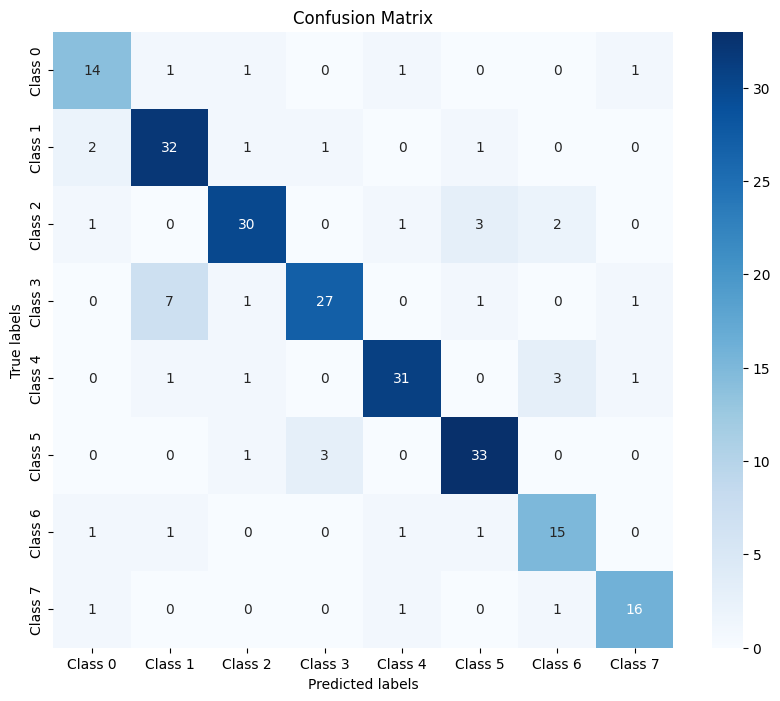

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76        18
           1       0.76      0.86      0.81        37
           2       0.86      0.81      0.83        37
           3       0.87      0.73      0.79        37
           4       0.89      0.84      0.86        37
           5       0.85      0.89      0.87        37
           6       0.71      0.79      0.75        19
           7       0.84      0.84      0.84        19

    accuracy                           0.82       241
   macro avg       0.81      0.82      0.81       241
weighted avg       0.83      0.82      0.82       241



In [56]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


## dumping

In [59]:
import joblib
import os

save_dir = r"C:\Users\Dell\Downloads\emotion_det\final3\female_models"

model_path = os.path.join(save_dir, "female_model.keras")
joblib.dump(model, model_path)
scaler_path = os.path.join(save_dir, "female_scaler.keras")
joblib.dump(scaler, scaler_path)


['C:\\Users\\Dell\\Downloads\\emotion_det\\final3\\female_models\\female_scaler.keras']

In [60]:
a = os.path.join(save_dir, "train_features_female.keras")
b = os.path.join(save_dir, "test_features_female.keras")

c = os.path.join(save_dir, "train_lables_female.keras")
d = os.path.join(save_dir, "test_labels_female.keras")

joblib.dump(train_features,a)
joblib.dump(test_features,b)
joblib.dump(train_labels,c)
joblib.dump(test_labels,d)

['C:\\Users\\Dell\\Downloads\\emotion_det\\final3\\female_models\\test_labels_female.keras']